# Setup

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip -f

In [1]:
"""
Install in 
- python==3.10.4
- cuda 11.4 in Captain server.
"""

# !pip install --verbose --no-cache-dir torch-scatter
# !pip install --verbose --no-cache-dir torch-sparse
# !pip install --verbose --no-cache-dir torch-cluster
# !pip install torch-geometric 
!pip install pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu115.html
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install tensorboardX networkx matplotlib
!pip install protobuf==3.20

Using pip 21.2.2 from /home/chris/anaconda3/envs/gnn/lib/python3.7/site-packages/pip (python 3.7)
    Running command python setup.py egg_info
    /home/chris/anaconda3/envs/gnn/lib/python3.7/site-packages/setuptools/dist.py:760: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
      % (opt, underscore_opt)
    running egg_info
    creating /tmp/pip-pip-egg-info-ouctoxku/torch_scatter.egg-info
    writing /tmp/pip-pip-egg-info-ouctoxku/torch_scatter.egg-info/PKG-INFO
    writing dependency_links to /tmp/pip-pip-egg-info-ouctoxku/torch_scatter.egg-info/dependency_links.txt
    writing requirements to /tmp/pip-pip-egg-info-ouctoxku/torch_scatter.egg-info/requires.txt
    writing top-level names to /tmp/pip-pip-egg-info-ouctoxku/torch_scatter.egg-info/top_level.txt
    writing manifest file '/tmp/pip-pip-egg-info-ouctoxku/torch_scatter.egg-info/SOURCES.txt'
    reading manifest file 

In [12]:
!python -V

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn        # GNN module 
import torch_geometric.utils as pyg_utils  # GNN Utility Function
import torch_geometric.transforms as T


import time
from datetime import datetime

import networkx as nx                      # visualize Graph Structure 
import numpy as np
import torch
import torch.optim as optim

# dataset
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

# visualize 
from tensorboardX import SummaryWriter     
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Python 3.10.4


# Define the model
![](gnn_model.png)

## torch_geometric

In [13]:
class GNNStack(nn.Module):      # stacking of Graph Convolutions 
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        # nn.ModuleList() : nn.Module()을 list로 정리! 각 layer를 list로 전달하고, layer의 iterator를 만듭니다. 
        self.convs = nn.ModuleList()    
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    # task에 따른 convolution layer를 만들어 줍니다. 
    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':  # node classification 
            return pyg_nn.GCNConv(input_dim, hidden_dim)
            # return CustomConv(input_dim, hidden_dim) : run my method 
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        '''
        x : feature matrix (# of nodes, # of node feature dim) 
        edge_index : sparse adj list, 연결된 edge에 대한 node 저장  
                     ex. node 1 : [1,4,6]
        batch : (array) batch마다 node 개수가 달라지므로 -> 어떤 node가 어떤 graph에 속하는지에 대한 정보 저장 
                ex. [1,1,1,1,1] : 5 nodes in graph 1 , [2,2,2] : 3 nodes in graph 2 
        '''

        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:         # feature 없으면 -> constant 
          x = torch.ones(data.num_nodes, 1)

        # Neural Network 
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)    # Conv Layer 
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':                # mean pooling : average all the nodes 
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)     

    def loss(self, pred, label):
        return F.nll_loss(pred, label)          # negative log-likelihood 

## Custom model

In [14]:
class CustomConv(pyg_nn.MessagePassing):    # inherenting from MessagePassing 
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # Neighborhood Aggregation : Mean, Max, Add, ... 
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        '''
        x : feature matrix 
        edge_index : connectivity, Adj list in the edge index  
        '''

        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # original code 
        # Add self-loops to the adjacency matrix : neighbor + self 
        # pyg_utils.add_self_loops(edge_index, num_nodes = x.size(0))   # A + I 

        # 여기에서는 remove self-loops : skip layer on top of that 
        edge_index, _ = pyg_utils.remove_self_loops(edge_index)    

        # Transform node feature matrix.
        self_x = self.lin_self(x)   # B 
        # x = self.lin(x)           # W 

        return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x))

    def message(self, x_i, x_j, edge_index, size):
        '''
        GCN : D^(-1/2)*A*D(1/2)*W*X
        x_i : self  
        x_j : neighborhood 
        '''

        # Compute messages
        # x_j has shape [E, out_channels]

        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels] : add additional layer after message passing 

        # GraphSAGE : L2 Normalization 
        # F.normalize(aggr_out, p=2, dim=-1) 

        return aggr_out

In [15]:
# Custom Model 을 사용하는 경우, GNNStack class 내의 build_conv_model return 값을 다음과 같이 수정해 주면 됩니다. 

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            # return pyg_nn.GCNConv(input_dim, hidden_dim)
            return CustomConv(input_dim, hidden_dim) # run my method 
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

IndentationError: unexpected indent (954007626.py, line 3)

# Training Setup
## Train

In [25]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

## Validation / Test

In [26]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        # mask 를 통해 validation, test 결정 
        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

## Training the model

In [28]:
# Setting TensorboardX in Colab 
port_number = '6009'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port {} &'
    .format("./log", port_number)
)
get_ipython().system_raw(f'./ngrok http {port_number} &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://ae7a-211-42-215-6.ngrok.io


TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.9.0 at http://0.0.0.0:6009/ (Press CTRL+C to quit)


In [29]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/cora', name='cora')
task = 'node'

model = train(dataset, task, writer)

/home/chris/anaconda3/envs/gnn/lib/python3.10/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0. Loss: 2.0289. Test accuracy: 0.2510
Epoch 10. Loss: 0.4400. Test accuracy: 0.7600
Epoch 20. Loss: 0.0475. Test accuracy: 0.7940
Epoch 30. Loss: 0.0190. Test accuracy: 0.7650
Epoch 40. Loss: 0.0183. Test accuracy: 0.7320
Epoch 50. Loss: 0.0182. Test accuracy: 0.7760
Epoch 60. Loss: 0.0531. Test accuracy: 0.7780
Epoch 70. Loss: 0.0163. Test accuracy: 0.7240
Epoch 80. Loss: 0.0284. Test accuracy: 0.7560
Epoch 90. Loss: 0.0176. Test accuracy: 0.7520
Epoch 100. Loss: 0.0055. Test accuracy: 0.7480
Epoch 110. Loss: 0.0311. Test accuracy: 0.7560
Epoch 120. Loss: 0.0003. Test accuracy: 0.7360
Epoch 130. Loss: 0.0216. Test accuracy: 0.7380
Epoch 140. Loss: 0.0053. Test accuracy: 0.7490
Epoch 150. Loss: 0.0023. Test accuracy: 0.7210
Epoch 160. Loss: 0.0006. Test accuracy: 0.7740
Epoch 170. Loss: 0.0036. Test accuracy: 0.7730
Epoch 180. Loss: 0.0003. Test accuracy: 0.7910
Epoch 190. Loss: 0.0016. Test accuracy: 0.7910


# Visualize Node Embeddings

In [32]:
loader = DataLoader(dataset, batch_size=64, shuffle=True)
for batch in loader:
    print(batch)
    break

DataBatch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], batch=[2708], ptr=[2])


/home/chris/anaconda3/envs/gnn/lib/python3.10/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


/home/chris/anaconda3/envs/gnn/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/chris/anaconda3/envs/gnn/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


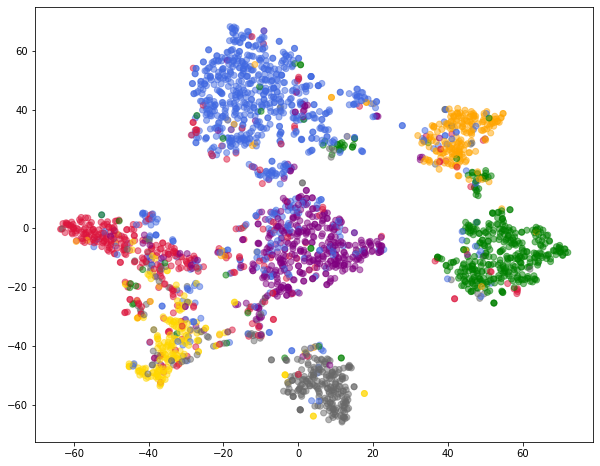

In [30]:
color_list = ["crimson", "orange", "green", "royalblue", "purple", "dimgrey", "gold"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))

plt.figure(figsize=(10, 8))
plt.scatter(xs, ys, color=colors, alpha=0.5)

# Learning Unsupervised Embeddings with Graph AutoEncoders

In [35]:
# VGAE : variational graph auto-encoder
# Knowledge Graph, Graph Reasoning 

class Encoder(torch.nn.Module):
    '''
    Encoder : Graph Conv to get embeddings 
    Decoder : inner product -> 2개 node 사이의 값이 크면, there's a likely link between them 
    '''

    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

def train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)    # reconstruction loss 
    loss.backward()
    optimizer.step()
    
    writer.add_scalar("loss", loss.item(), epoch)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [36]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid("/tmp/citeseer", "Citeseer", transform = T.NormalizeFeatures())
data = dataset[0]

channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())
# encoder: written by us; decoder: default (inner product)
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None

# data = model.split_edges(data) # split_edges 안 돌아가서 변경!  
data = pyg_utils.train_test_split_edges(data)   # construct positive/negative edges (for negative sampling!)
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train(epoch)
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    writer.add_scalar("AUC", auc, epoch)
    writer.add_scalar("AP", ap, epoch)
    if epoch % 10 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

CUDA availability: True
Epoch: 010, AUC: 0.6860, AP: 0.7506
Epoch: 020, AUC: 0.8193, AP: 0.8280
Epoch: 030, AUC: 0.8247, AP: 0.8281
Epoch: 040, AUC: 0.8199, AP: 0.8218
Epoch: 050, AUC: 0.8207, AP: 0.8243
Epoch: 060, AUC: 0.8343, AP: 0.8359
Epoch: 070, AUC: 0.8519, AP: 0.8520
Epoch: 080, AUC: 0.8563, AP: 0.8577
Epoch: 090, AUC: 0.8773, AP: 0.8769
Epoch: 100, AUC: 0.9034, AP: 0.9024
Epoch: 110, AUC: 0.8996, AP: 0.9004
Epoch: 120, AUC: 0.8986, AP: 0.9000
Epoch: 130, AUC: 0.8965, AP: 0.8980
Epoch: 140, AUC: 0.8924, AP: 0.8948
Epoch: 150, AUC: 0.8921, AP: 0.8942
Epoch: 160, AUC: 0.8900, AP: 0.8923
Epoch: 170, AUC: 0.8883, AP: 0.8913
Epoch: 180, AUC: 0.8863, AP: 0.8895
Epoch: 190, AUC: 0.8881, AP: 0.8913
Epoch: 200, AUC: 0.8901, AP: 0.8941


/home/chris/anaconda3/envs/gnn/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/chris/anaconda3/envs/gnn/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


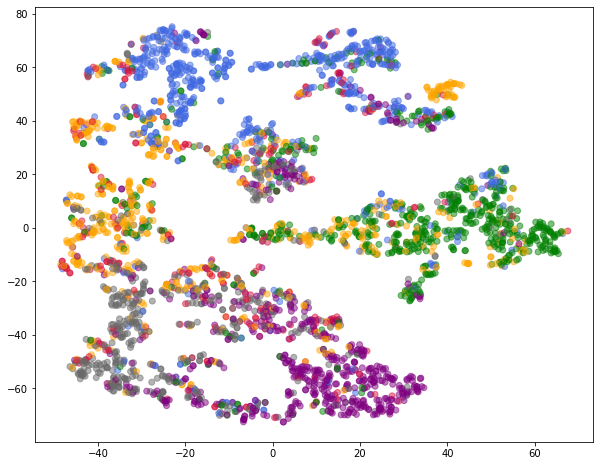

In [37]:
model.eval()
z = model.encode(x, train_pos_edge_index)
colors = [color_list[y] for y in labels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))

plt.figure(figsize=(10, 8))
plt.scatter(xs, ys, color=colors, alpha=0.5)
plt.show()

# Reference
- https://tobigs.gitbook.io/tobigs-graph-study/chapter9.
- https://velog.io/@tobigs-gnn1213/9.-Graph-Neural-Networks-Hands-on-Session